In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f(x):
  return 3* x**2- 4*x + 5

In [ ]:
f(1)

4

In [ ]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

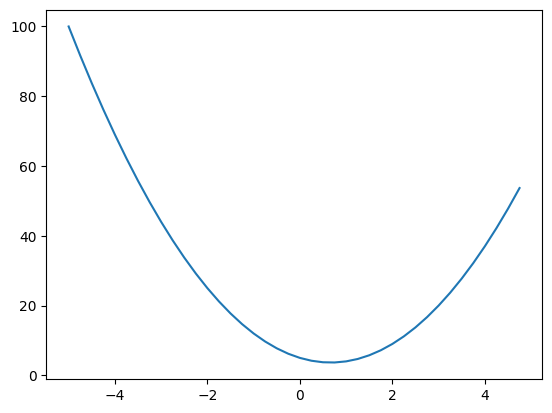

In [ ]:
plt.plot(xs, ys)

In [ ]:
def f_(x):
  h = 0.001
  return (f(x+h) - f(x))/h

In [ ]:
f_(3)

14.00300000000243

In [ ]:
x = np.random.uniform(-5,5)

In [ ]:
x

4.463846005808005

In [ ]:
f(x)

9.758427594825916

In [ ]:
x += -0.1 * f_(x)
f(x)

4.642374675565955

In [ ]:
x

0.09637200338598184

In [ ]:
def f(x ,y):
    return x ** 2 + y ** 2

In [ ]:
def f_(x,y):
    h = 0.001
    x_ = (f(x+h,y) - f(x,y)) / h
    y_ = (f(x,y+h) - f(x,y)) / h
    return x_,y_

In [ ]:
x = np.random.uniform(-5,5)
y = np.random.uniform(-5,5)

In [ ]:
x_ , y_ = f_(x,y)
x += -0.1 * x_
y += -0.1 * y_

print(x,y)

1.6090014263683958 0.6572191963814786


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:
  def __init__(self,data, _prev=(), _op = '', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_prev)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out  = Value(self.data + other.data, (self, other) , "+")
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __radd__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    return self + other

  def __sub__(self, other):
    return self + other * -1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supports int/float"
    out = Value(self.data ** other, (self,), f'**{other}')
    def _backward():
      self.grad += out.grad * other * (self.data ** (other - 1))
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out  = Value(self.data * other.data, (self, other) , "*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def sigmoid(self):
    s = 1 / (1 + np.exp(-self.data))
    out = Value(s, (self,), 'sigmoid')
    def _backward():
      # self.grad += (1 - out.data) * out.grad
      self.grad += out.grad * (s * (1 - s))
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
a = Value(3.0,label="a")
a.data

3.0

In [ ]:
a

Value(data=3.0)

In [ ]:
b=Value(-2.0,label="b")
b

Value(data=-2.0)

In [ ]:
a = Value(3.0, label='a')
b = Value(-2.0, label='b')

c = a * b; c.label = 'c'
d = a + b; d.label = 'd'

o = c * d; o.label ='o'

o

Value(data=-6.0)

In [ ]:
c._prev

{Value(data=-2.0), Value(data=3.0)}

In [ ]:
o.grad = 1.0
o.backward()

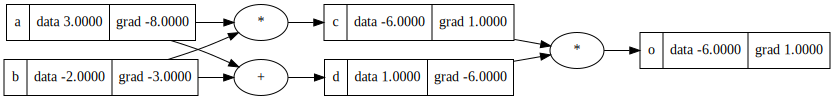

In [ ]:
draw_dot(o)

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

w1 = Value(0.5, label='w1')
w2 = Value(0.3, label='w2')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

b = Value(0.6, label='b')

x1w1x2w2b = x1w1x2w2 + b; x1w1x2w2b.label = 'x1w1x2w2 + b'

o = x1w1x2w2b.sigmoid(); o.label = 'o'

o.backward()


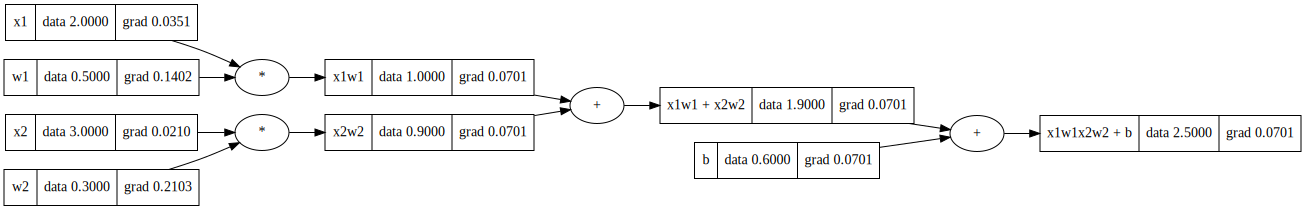

In [ ]:
draw_dot(x1w1x2w2b)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.bias = Value(np.random.uniform(-1, 1))
    self.weights = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]

  def __call__(self, x):
    z = sum([w * xi for w, xi in zip(self.weights, x) ]) + self.bias
    return z.sigmoid()

  def parameters(self):
    return self.weights + [self.bias]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs if len(outs) > 1 else outs[0]

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n = MLP(3,[4, 1])

In [ ]:
xs = np.random.choice(np.arange(-3, 3, 0.5), size=(4, 3))

In [ ]:
xs

array([[-3. , -3. ,  2. ],
       [ 2. , -1.5,  0.5],
       [-2. , -1. ,  2. ],
       [-0.5,  0. , -1.5]])

In [ ]:
ys = np.random.choice(np.arange(0, 2, 1.0), size=(4, 1))
ys

array([[1.],
       [1.],
       [0.],
       [1.]])

In [ ]:
for k in range(2000):
  #forward pass
  youts = [n(x) for x in xs]
  loss = sum([(yo - y) ** 2 for yo, y in zip(youts, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #gradient descend
  for p in n.parameters():
    p.data -= 0.05 * p.grad

In [ ]:
youts = [n(x) for x in xs]
youts

[Value(data=[0.50632045]),
 Value(data=[0.93851456]),
 Value(data=[0.50895953]),
 Value(data=[0.99849529])]